# Notebook to train a model to diagnose thoracic pathology from chest X-rays

The purpose of this Jupyter notebook is to demonstrate how we can build a AI-based Radiologist system using Apache Spark and Analytics Zoo to detect pneumonia and other diseases from chest x-ray images. The X-rays are made available by the United States’ National Institutes of Health (NIH). The dataset contains over 120,000 images of frontal chest x-rays, each potentially labeled with one or more of fourteen different thoracic pathologies. We show how to build a multi-label image classification model in a distributed Apache Spark infrastructure, and demonstrate how to build complex image transformations and deep learning pipelines using Analytics Zoo with scalability and ease of use.

For instructions on prerequisites for this notebook, refer to the GitHub readme.

## Import the required packages
The following modules are for this notebook.

In [17]:
import warnings
# Ignoring the warnings to improve readability of the notebook
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import random
import time
import numpy as np
from math import ceil
from bigdl.optim.optimizer import SGD, SequentialSchedule, Warmup, Poly,\
    Plateau, EveryEpoch, TrainSummary,\
    ValidationSummary, SeveralIteration, Step, L2Regularizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.storagelevel import StorageLevel
from zoo.common.nncontext import *
from zoo.feature.image.imagePreprocessing import *
from zoo.feature.common import ChainedPreprocessing
from zoo.pipeline.api.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from zoo.pipeline.api.keras.metrics import AUC
from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.net import Net
from zoo.pipeline.nnframes import NNEstimator, NNImageReader
from zoo.pipeline.api.keras.objectives import BinaryCrossEntropy
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt

## Transfer learning and loading pre-trained models
We use transfer learning for training the model. In the following cell, we show how to load a pre-trained Inception, ResNet-50, VGG, and a DenseNet model. These models are pre-trained with ImageNet dataset and are available [here](https://analytics-zoo.github.io/0.4.0/#ProgrammingGuide/image-classification/). Only one of the models is used in the actual training. You can switch between the different models below by calling the appropritate function to  see how they perform.

*get_resent_model* function below is used to load an __ResNet-50__ Model. The function accepts two parameters:
- *model_path* - This is the path in your HDFS where the model pretrained model is located
- *label_length* - This is the number of labels for a given task. For this exercise, the Xrays can have 14 diseases. *label-length* is always 14.

The function does the following:
-  *Net.load_bigdl()* - loads a BigDL model. _Net_ package can be used to load models from other frameworks like Caffe, Torch and TensorFlow. This returns a _Model_.
- *new_graph()* removes layers after "pool5"
- *Input()* creates a new layer for the Xray images. The images are resized to 224x224 and have three channels
- The input layer is added to the model using *to_keras*
- We then flatten the neural network, add dropout and apply regularization

    

In [2]:
# Function to load a ResNet50 model
def get_resnet_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    inputNode = Input(name="input", shape=(3, 224, 224))
    resnet = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(resnet)
    dropout = Dropout(0.2)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

# Function to load an Inception model
def get_inception_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5/drop_7x7_s1"])
    inputNode = Input(name="input", shape=(3, 224, 224))
    inception = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(inception)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1),\
                   activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel


# Function to load a VGG model
def get_vgg_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    inputNode = Input(name="input", shape=(3, 224, 224))
    vgg_16 = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(vgg_16)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

# Function to load a DenseNet model
def get_densenet_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    inputNode = Input(name="input", shape=(3, 224, 224))
    densenet = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(densenet)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

## Learning Rate Scheduler for SGD and Adam optimizer 

We tried two optimizers: SGD and Adam. We used use learning rate schduler with both. Here is an exaplanation of some key parameters used:
- *SequentialSchedule* - *SequentialSchedule* is used to combine multiple learning rate scheduler. In this exercise, we combine two learning rate scheduler. First we increase the learning rate scheduler using *Warmup*, then we use *Plateau* to gradually reduce the learning rate. For more information, refer to this [link](https://github.com/intel-analytics/BigDL/blob/6ab9f3d65ed1f9c005b003bf587ab22988a21ef9/docs/docs/APIGuide/Optimizers/Learningrate-Scheduler.md).
-  *num_epoch* - Number of Epochs you want to train the model
- *batchSize* - BatchSize used in training. This must be a multiple of number of Spark executors * number of cores in each executor
- *trainingCount* - Total records in the training dataset
- *warmupEpoch* - Specifies the number of warm up Epochs. The learning rate will increase during the warm up epochs
- *initlr* - is the initial learning rate
- *maxlr* - is the maximum learning rate
- *Warmup* scheduler increases the learning rate by *Warmupdelta* for *warmup_iteration*
- *Plateau* scheduer decreases the learning rate for *cooldownIteration*
  

In [3]:
def get_sgd_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    warmupEpoch = 10
    warmup_iteration = warmupEpoch * iterationPerEpoch
    initlr = 1e-6
    maxlr = 0.001
    warmupDelta = (maxlr - initlr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ), 
                   cooldownIteration)
    optim = SGD(learningrate=initlr, momentum=0.9, dampening=0.0, nesterov=True,
                leaningrate_schedule=lrSchedule)
    return optim

def get_adam_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    warmupEpoch = 5
    warmup_iteration = warmupEpoch * iterationPerEpoch
    initlr = 1e-7
    maxlr = 0.0001
    warmupDelta = (maxlr - initlr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ),
                   cooldownIteration)
    optim = Adam(lr=initlr, schedule=lrSchedule)
    return optim

## Calculate the AUC-ROC for a disease

The following function calculates the ROC for disease *k*. We use ML Pipeline *BinaryClassificationEvaluator* for this.

In [4]:
def get_auc_for_kth_class(k, df, label_col="label", prediction_col="prediction"):
    get_Kth = udf(lambda a: a[k], DoubleType())
    extracted_df = df.withColumn("kth_label", get_Kth(col(label_col))) \
        .withColumn("kth_prediction", get_Kth(col(prediction_col))) \
        .select('kth_label', 'kth_prediction')
    roc_score = BinaryClassificationEvaluator(rawPredictionCol='kth_prediction',
                                              labelCol='kth_label', metricName="areaUnderROC").evaluate(extracted_df)
    return roc_score

## Plot AUC
This function is used to evaluate and printout auc for all 14 classes 


In [5]:
def plotingAuc(roc_auc_label):
    lists=[]
    lists = sorted(roc_auc_label.items()) 
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation","Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    x, y =zip(*lists)
    label_map = {k: v for v, k in enumerate(label_texts)}
    rng = np.random.RandomState(0)
    fig, ax = plt.subplots(figsize=(10, 5))
    sizes = 500 * rng.rand(100)
    colors = ['#005249','#2300A8', '#00A658', '#00A6B8','#00A6BC', '#00AA58','#1805db', '#154406', '#631950','#000000','#850e04','#84b701','#adf802','#042e60']
    plt.ylabel("AUC")
    plt.xlabel("Classes")
    plt.title("AUC for all 14 classes")
    plt.scatter(x, y,  alpha=0.50, color=colors,s=sizes,   cmap='viridis',  marker = '*')
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels(x, rotation=45 )
    return plt

## Evaluating the model and plot AUC 

In [6]:
def evaluate_and_plot(testDF):
    predictionDF = nnModel.transform(testDF).persist(storageLevel=StorageLevel.DISK_ONLY)
    label_texts= ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    label_map = {k: v for v, k in enumerate(label_texts)}
    chexnet_order = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
     "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    total_auc = 0.0
    roc_auc_label =dict()
    for i in chexnet_order:
        roc_score = get_auc_for_kth_class(label_map[i], predictionDF)
        total_auc += roc_score
        print('{:>12} {:>25} {:>5} {:<20}'.format('ROC score for ', i, ' is: ', roc_score))
        roc_auc_label[i]=(roc_score)
    print("Average AUC: ", total_auc / float(label_length))
    plt = plotingAuc(roc_auc_label)
    plt.show()

## Main program


In [7]:
random.seed(1234)
batch_size = 1024 
num_epoch = 15
# 
#    model_path - Path for the pre-trained model file, data and the location to save the model after training. 
#                 The model path must match the function you are calling (ResNet-50, VGG or DenseNet)
#    image_path - Path to all images
#    label_path - Path to the label file (Data_Entry_2017.csv) available from NIH
#    save_path = Path to save the model and intermediate results 
model_path ="hdfs:///datasets/xray_files/xray/analytics-zoo_resnet-50_imagenet_0.1.0.model" 
image_path = "hdfs:///datasets/xray_files/xray/all_images"
label_path = "hdfs:///datasets/xray_files"
save_path = "hdfs:///datasets/xray_files/save" 

# Get Spark Context
sparkConf = create_spark_conf().setAppName("Chest X-ray Training")
sc = init_nncontext(sparkConf)
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()

# Make sure the batchsize is a multiple of (Number of executors * Number of cores)
numexecutors = len(sc._jsc.sc().statusTracker().getExecutorInfos()) - 1
numcores = int(sc.getConf().get('spark.executor.cores','1'))

print "Number of Executors = " +str(numexecutors)
print "Number of Cores = " + str(numcores)
print "Batch Size = " + str(batch_size)
if batch_size%(numexecutors*numcores)==0:
    print("Batchsize is a multiple of (Number of Executors * Number of cores. Good to proceed")
else:
    print("Batchsize is NOT a multiple of (Number of Executors * Number of cores). Do not proceed !")

Number of Executors = 4
Number of Cores = 32
Batch Size = 1024
Batchsize is a multiple of (Number of Executors * Number of cores. Good to proceed


## Load the data
We then load the dataset. NIH has __[released](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)__ the chest xray has two sets (training and test). We have created a [notebook](ConvertXray-ConvertImages.ipynb) to read the Xray images from NIH an save them as training and test datasets (in two folders /trainingDF and /testDF). In the below code, we read these dataframes and combine them to a single Spark dataframe. We then sploy them to the actual training and validation Dataframes for our model. We use *ramdomSplit* to split the data.



In [8]:
label_length = 14
label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia", "Pneumothorax",
               "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
label_map = {k: v for v, k in enumerate(label_texts)}

def text_to_label(text):
    arr = [0.0] * len(label_texts)
    for l in text.split("|"):
        if l != "No Finding":
            arr[label_map[l]] = 1.0
    return arr

getLabel = udf(lambda x: text_to_label(x), ArrayType(DoubleType()))
getName = udf(lambda row: os.path.basename(row[0]), StringType())
imageDF = NNImageReader.readImages(image_path, sc, resizeH=256, resizeW=256, image_codec=1) \
    .withColumn("Image_Index", getName(col('image')))

labelDF = spark.read.load(label_path + "/Data_Entry_2017.csv", format="csv", sep=",", inferSchema="true", header="true") \
        .select("Image Index", "Finding Labels") \
        .withColumn("label", getLabel(col('Finding Labels'))) \
        .withColumnRenamed('Image Index', 'Image_Index')

totalDF = imageDF.join(labelDF, on="Image_Index", how="inner").withColumnRenamed("Finding Labels", "Finding_Labels")

(trainingDF, validationDF) = totalDF.randomSplit([0.7, 0.3])
print("Number of training images: ", trainingDF.count())
print("Number of validation images: ", validationDF.count())

('Number of training images: ', 78615)
('Number of validation images: ', 33505)


## Load the pre-trained model and optimiser
We first load the pre-trained model. We use ResNet in the below example. It can be changed to any of the above defined models. We then load the optimiser

In [9]:
# Load the pretrained model
xray_model = get_resnet_model(model_path, label_length)
# Define the Optimiser
optim_method = get_adam_optimMethod(num_epoch, trainingDF.count(), batch_size)

creating: createZooKerasInput
creating: createZooKerasGlobalAveragePooling2D
creating: createZooKerasDropout
creating: createL2Regularizer
creating: createL2Regularizer
creating: createZooKerasDense
creating: createZooKerasModel
creating: createSequentialSchedule
creating: createWarmup
creating: createPlateau
creating: createZooKerasAdam


## Image pre-processing

We build *ChainedPreprocessing* to combine the following preprocessing.
- *RowToImageFeature* - converts a Spark row to a BigDL ImageFeature
- *ImageCenterCrop* - resizes the image to 224 x 224
- *ImageHFlip* - Randomly flips 50% of the image horizontally
- *ImageBrightness* - Randomly adjust the brigthness of 50% of the images
- *ImageChannelNormalize* - Normalize the images by subtracting the mean value of the ImageNet images

In [10]:
transformer = ChainedPreprocessing(
            [RowToImageFeature(), ImageCenterCrop(224, 224), ImageRandomPreprocessing(ImageHFlip(), 0.5),
             ImageRandomPreprocessing(ImageBrightness(0.0, 32.0), 0.5),
             ImageChannelNormalize(123.68, 116.779, 103.939), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageCenterCrop
creating: createImageHFlip
creating: createImageRandomPreprocessing
creating: createImageBrightness
creating: createImageRandomPreprocessing
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Save training and validation summary 

Training and validation summary can be saved in the following directories

In [11]:
train_summary = TrainSummary(log_dir="xray_save_summary", app_name="Chest X-ray Training")
val_summary = ValidationSummary(log_dir="xray_save_summary", app_name="Chest X-ray Training")
train_summary.set_summary_trigger("LearningRate", SeveralIteration(50))
train_summary.set_summary_trigger("Loss", SeveralIteration(50))

creating: createTrainSummary
creating: createValidationSummary
creating: createSeveralIteration
creating: createSeveralIteration


JavaObject id=o462

### Define the Classifier

In [12]:
classifier = NNEstimator(xray_model, BinaryCrossEntropy(), transformer) \
            .setBatchSize(batch_size) \
            .setMaxEpoch(num_epoch) \
            .setFeaturesCol("image") \
            .setCachingSample(False) \
            .setValidation(EveryEpoch(), validationDF, [AUC()], batch_size) \
            .setTrainSummary(train_summary) \
            .setValidationSummary(val_summary) \
            .setOptimMethod(optim_method)

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createEveryEpoch
creating: createAUC


### Train the model

In [13]:
%%time
nnModel = classifier.fit(trainingDF)

creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 1.02 s, sys: 324 ms, total: 1.34 s
Wall time: 4h 18min 42s


### Evaluate the model and plot AUC accuracy for training Data
This can be done to get an idea of how our model is performing. Results from training data evaluation will not be published.

Evaluating the model on training data:
ROC score for                Atelectasis  is:  0.839447754325      
ROC score for               Cardiomegaly  is:  0.933189372638      
ROC score for                   Effusion  is:  0.904531511225      
ROC score for               Infiltration  is:  0.743218766366      
ROC score for                       Mass  is:  0.880717202753      
ROC score for                     Nodule  is:  0.800499521475      
ROC score for                  Pneumonia  is:  0.781081095129      
ROC score for               Pneumothorax  is:  0.913827716244      
ROC score for              Consolidation  is:  0.82365777975       
ROC score for                      Edema  is:  0.91653700172       
ROC score for                  Emphysema  is:  0.920766403585      
ROC score for                   Fibrosis  is:  0.842863717345      
ROC score for         Pleural_Thickening  is:  0.818484679669      
ROC score for                     Hernia  is:  0.781668303975      
('Average

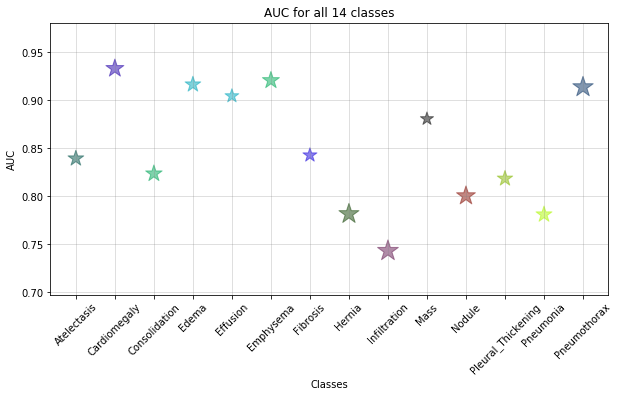

In [14]:
print("Evaluating the model on training data:")
evaluate_and_plot(trainingDF)

SQLContext(sc).clearCache()

### Evaluate the model and plot AUC accuracy for Validation Data

Evaluating the model on validation data:
ROC score for                Atelectasis  is:  0.798047499918      
ROC score for               Cardiomegaly  is:  0.892335320102      
ROC score for                   Effusion  is:  0.873232913191      
ROC score for               Infiltration  is:  0.703745426351      
ROC score for                       Mass  is:  0.817617373733      
ROC score for                     Nodule  is:  0.732289249247      
ROC score for                  Pneumonia  is:  0.72084013157       
ROC score for               Pneumothorax  is:  0.872177030029      
ROC score for              Consolidation  is:  0.799862329631      
ROC score for                      Edema  is:  0.882317917159      
ROC score for                  Emphysema  is:  0.876294427404      
ROC score for                   Fibrosis  is:  0.78241840828       
ROC score for         Pleural_Thickening  is:  0.777476065972      
ROC score for                     Hernia  is:  0.801740153188      
('Avera

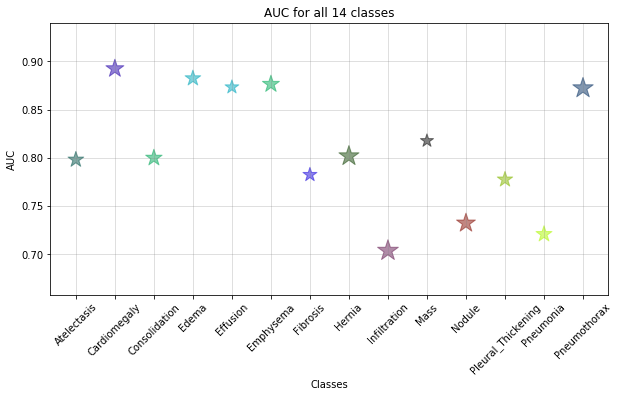

In [15]:
print("Evaluating the model on validation data:")
evaluate_and_plot(validationDF)

### Save the model for inference

In [18]:
model_path = save_path + '/xray_model_' + time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
nnModel.model.saveModel(model_path + ".bigdl", model_path + ".bin", True)
print('Model saved at: ', model_path)

('Model saved at: ', 'hdfs:///datasets/xray_files/save/xray_model_2019_03_22_09_41_14')
